In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# from torch.utils.data import *

import time
import random
import re

import matplotlib.pyplot as plt 
%matplotlib inline

import pdb
from tqdm.auto import tqdm

# Data Detail

```

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)
        
        
u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test



u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  
              Users and items are numbered consecutively from 1.  
              The data is randomly ordered. 
              This is a tab separated list of user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   
```

# Import Function

In [2]:
def load_data(filename):
    data_list = []
    with open(filename, 'r') as data:
        for line in tqdm(data):
            user_id, item_id, rating, timestamp = line.split('\t')
            data_list.append([int(user_id), int(item_id), int(rating)])
            
    print('data loading complete')
    return data_list

def torch_load_data(filename):
    data_list = []
    with open(filename, 'r') as data:
        for line in tqdm(data):
            user_id, item_id, rating, timestamp = line.split('\t')
            data_list.append(torch.tensor([int(user_id), int(item_id), int(rating)]))
    print('data loading complete')
    return data_list

def torch_load_data_csv(filename='ml-latest-small/ratings.csv'):
    '''user_id, item_id, rating, timestamp
    '''
    data_list = []
    df = pd.read_csv(filename)
    print(df.columns)
    print(df.shape)
    for line in df.values:
        data_list.append(torch.tensor([int(line[0]), int(line[1]), int(line[2])]))
    print('data loading complete')
    return data_list


def data_handler():
    
    def data():
        data_list = []
        filename = 'ml-100k/u.data'
        with open(filename, 'r') as data:
            for line in tqdm(data):
                user_id, item_id, rating, timestamp = line.split('\t')
                data_list.append([int(user_id), int(item_id), int(rating), timestamp.strip()])
        print('data loading complete')

        df = pd.DataFrame(data_list, columns =['user_id', 'movie_id', 'rating', 'timestamp'])
        return df 
    
    def item():
        data_list = []
        filename = 'ml-100k/u.item'
        with open(filename, 'r', encoding="ISO-8859-1") as data:
            for line in tqdm(data):
                lst = line.split('|')
                lst = [ele.strip() for ele in lst]
                data_list.append(lst)

        print('data loading complete')

        columns = [ 'movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', \
                    'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', \
                    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western'] 

        df = pd.DataFrame(data_list, columns =columns)
        return df 
    
    data = data()
    item = item()
    return data, item

# Load Data

In [3]:
train_data = load_data('ml-100k/u1.base')
test_data = load_data('ml-100k/u1.test')
data_list = torch_load_data('ml-100k/u.data')

# data_list = torch_load_data_csv(filename='ml-latest-small/ratings.csv')    




data loading complete



data loading complete



data loading complete


In [4]:
len(data_list)

100000

# Embedding mehtods for Matrix Factorization

$$r_{ui}=u+b_i+b_u+ q_i^Tp_u$$

$$ u = \text {Constant denoting the over all average rating} $$
$$b_i = \text{ bias for item i}$$
$$b_u = \text{ bias for user u}$$
$$q_i = \text{ bias latent factor}$$
$$P_u = \text{ user latent factor }$$


In [5]:
class Matrix_factorization(nn.Module):
    '''Matrix Factorization of user and items from rating
       ref : Matrix Factorization Techniques for Recommender Systems
       ref : Probabilistic Matrix Factorization

       Parameter:
       ----
       len_u : number of users
       len_v : number of items
       dim : feature dimensions of lantent factor u and v
    '''
    def __init__(self,len_u,len_v,dim):
        super(Matrix_factorization,self).__init__()
        self.U = nn.Embedding(len_u,dim)
        self.V = nn.Embedding(len_v,dim)
        self.Ub = nn.Embedding(len_u,1)
        self.Vb = nn.Embedding(len_v,1)

    def forward(self,user, item):
        u_lant = self.U(user-1)
        v_lant = self.V(item-1)
        u_bias = self.Ub(user-1).squeeze_()
        v_bias = self.Vb(item-1).squeeze_()
        score = u_lant.view(1, -1).mm(v_lant.view(-1, 1)).squeeze_()
        score = score + u_bias + v_bias + mu
        return score

# Start training
- using SGD
- loss function = MSELoss

In [6]:
len_u = 943
len_v = 1682

# len_u = 610
# len_v = 9742

batch_size = 10
lr_rate = 1e-3
weight_decay= 0.001
epoch = 20
dim = 50

mu = np.mean([i[2] for i in data_list])
print(mu)

3.52986


In [7]:

#######################################

dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=True, num_workers=0)
model =  Matrix_factorization(len_u, len_v, dim)
sgd = torch.optim.SGD(model.parameters(), lr=lr_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

print('Begin training')
start = time.process_time()

history = {
    "loss":[],
    "accuracy":[]
}

for i in tqdm(range(epoch)):
    for batch in dataloader :  
        for user, item, rating in batch:
            sgd.zero_grad()
            predict = model(user, item)
            loss = criterion(predict, rating.float()) 
            loss.backward()
            sgd.step()

    loss = 0
    correct = 0
    total_count = 0
    for batch in dataloader :  
        for user, item, rating in batch:   
            predict = model(user, item)
            loss += criterion(predict, rating.float())
            
            diff = predict.item() - rating.float()
            if abs(diff) <= 1:
                correct += 1
            total_count += 1
            
    history['loss'].append(loss)
    history['accuracy'].append(correct/total_count)
    print('epoch : {0} / {1} loss = {2} accuracy = {3}'.format(i+1, epoch , np.sqrt(loss.item() / 100000), correct/total_count ))

end = time.process_time()
print('Training complete \n\nTime past : %.2f seconds'%(end-start))

Begin training


epoch : 1 / 20 loss = 3.307542138809421 accuracy = 0.25243
epoch : 2 / 20 loss = 2.154134832130988 accuracy = 0.38268
epoch : 3 / 20 loss = 1.6108950346003306 accuracy = 0.48798
epoch : 4 / 20 loss = 1.3143377015630344 accuracy = 0.5692
epoch : 5 / 20 loss = 1.1424859476706923 accuracy = 0.62661
epoch : 6 / 20 loss = 1.0405222171462751 accuracy = 0.66856
epoch : 7 / 20 loss = 0.9799363021390727 accuracy = 0.69636
epoch : 8 / 20 loss = 0.9442937589145657 accuracy = 0.71287
epoch : 9 / 20 loss = 0.9238036604847374 accuracy = 0.7232
epoch : 10 / 20 loss = 0.91280174805376 accuracy = 0.72929
epoch : 11 / 20 loss = 0.9075608622841776 accuracy = 0.73174
epoch : 12 / 20 loss = 0.9058995011865278 accuracy = 0.73248
epoch : 13 / 20 loss = 0.9063599933249481 accuracy = 0.73236
epoch : 14 / 20 loss = 0.9081361406749541 accuracy = 0.73072
epoch : 15 / 20 loss = 0.9106220830426857 accuracy = 0.72909
epoch : 16 / 20 loss = 0.9134679797343748 accuracy = 0.72738
epoch : 17 / 20 loss = 0.91644766796855

# Save and reload the model

In [8]:
# Specify a path
PATH = "model/state_dict_model.pt"

# Save
torch.save(model.state_dict(), PATH)

In [9]:
# Load
model = Matrix_factorization(len_u=943, len_v=1682, dim=50)
model.load_state_dict(torch.load(PATH))
model.eval()

Matrix_factorization(
  (U): Embedding(943, 50)
  (V): Embedding(1682, 50)
  (Ub): Embedding(943, 1)
  (Vb): Embedding(1682, 1)
)

In [10]:
user = data_list[0][0]
item = data_list[0][1]
predict = model(user, item)
predict

tensor(3.8889, grad_fn=<AddBackward0>)

In [11]:
np.round(predict.item(),2)

3.89

In [12]:
user

tensor(196)

# Connect the dot

In [13]:
ratings, movies = data_handler()

movies['movie_id'] = movies['movie_id'].astype('int64')
movies['movie_id'] = movies['movie_id'].astype('int64')

# movies.dtypes


data loading complete



data loading complete


In [14]:
ratings.head(3)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [15]:
movies.head(3)

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
merge = pd.merge(ratings, movies, on='movie_id')
merge.head(3)

,user_id,movie_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0


# Recommend Generator

In [18]:
def recommend_generator(user = 196, topk = 5):
    ''' generate the prediction rating for each records 
    '''
    def prediction(row, model, user):

        user = torch.tensor(user)
        item = torch.tensor(row)
        predict = model(user, item)
        return np.round(predict.item(),2)

    def fetch_year(row):
        '''
        string = "Kolya (1996)"
        m = re.search("([0-9]{4})",string).group(0)
        int(m)
        '''
        match = re.search("([0-9]{4})",row)
        try:
            return int(match.group(0))
        except:
            return 0

    # fetching the past watching records
    records = merge[merge['user_id']==user].sort_values(by=['rating'], ascending=False)
    records = records.iloc[0:5,:]
    print(f"User {user}")
    print("from rating, he/she like")
    print("movie_id  predict_rating  movie_title")
    print("==========================================================")
    for ele in records.to_dict('records'):
        print("{0}           {1}       {2}".format(ele["movie_id"], ele["rating"], ele["movie_title"]))


    # generating the topk movies from model 
    movies['predicted'] = movies['movie_id'].apply(prediction, args=(model, user))
    movies['year'] = movies['movie_title'].apply(fetch_year)
    rank = movies.sort_values(by=['predicted'], ascending=False)
    rank = rank.iloc[0:topk,:]

    print("\n")
    print("from rating, he/she might like")
    print("movie_id  predict_rating  movie_title")
    print("==========================================================")
    for ele in rank.to_dict('records'):
        print("{0}           {1}       {2}".format(ele["movie_id"], ele["predicted"], ele["movie_title"]))
        

# for example, we recommend user(196) the movies he/she might like based on the NN rating model.
recommend_generator(user = 196, topk = 5)

User 196
from rating, he/she like
movie_id  predict_rating  movie_title
285           5       Secrets & Lies (1996)
663           5       Being There (1979)
153           5       Fish Called Wanda, A (1988)
286           5       English Patient, The (1996)
692           5       American President, The (1995)


from rating, he/she might like
movie_id  predict_rating  movie_title
64           4.45       Shawshank Redemption, The (1994)
50           4.42       Star Wars (1977)
12           4.41       Usual Suspects, The (1995)
174           4.36       Raiders of the Lost Ark (1981)
408           4.32       Close Shave, A (1995)


# Model Accuracy Rate

In [20]:
def accuracy_evaluate():
    def prediction(row, model, user):

        user = torch.tensor(user)
        item = torch.tensor(row)
        predict = model(user, item)
        return np.round(predict.item(),2)

    validate = merge.copy()
    validate['predicted'] = validate['movie_id'].apply(prediction, args=(model, user))

    validate['diff'] = validate['predicted'] - validate['rating']
    validate['correct'] = validate['diff'].apply(lambda x: 1 if abs(x) <= 1 else 0)
    correct = validate['correct'].sum()
    accuracy = correct/validate.shape[0]
    print("Accuracy Rate {}%".format(accuracy*100))


accuracy_evaluate()

<ipython-input-20-aa1e5591d83c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user = torch.tensor(user)


Accuracy Rate 66.13900000000001%


# Draw the acc and loss plt

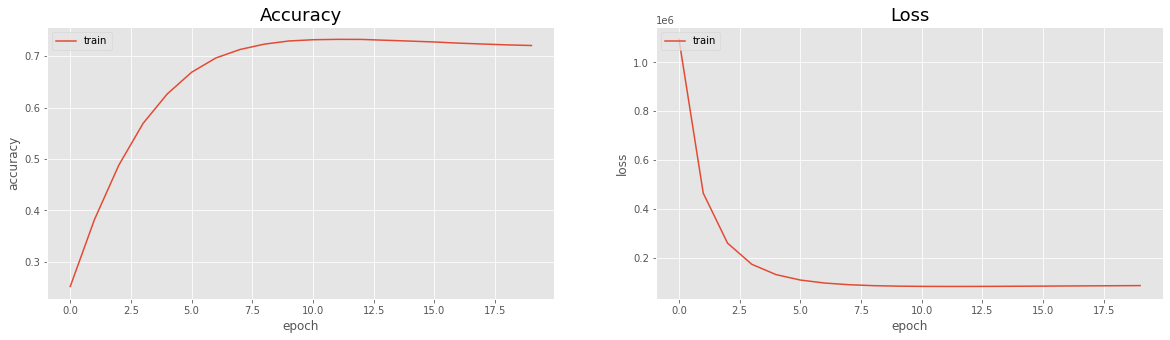

In [22]:
# Plot the progression of the classification accuracy over 20 epoach.
plt.style.use('ggplot')

fig, ax = plt.subplots(1,2,figsize=(20,5))

# summarize for accuracy
ax[0].plot(history.get('accuracy'),label='train')
# ax[0].plot(history.history['val_accuracy'],label ='test')

ax[0].set_title('Accuracy',fontsize=18)
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='upper left')

# # summarize for loss 
ax[1].plot(history.get('loss'), label='train')
# ax[1].plot(history.history['val_loss'], label ='test')

ax[1].set_title('Loss',fontsize=18)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='upper left')